In [4]:
import pandas as pd
import pandas_profiling as pp
import matplotlib as plt
import numpy as np
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3)
%matplotlib inline

In [37]:
import datetime

In [38]:
date_parser = lambda ts: datetime.strptime(ts, "%y-%m-%dT%H:%M:%SZ")
df = pd.read_csv('./pricing/aviasales_data_t.csv')
df['requested_at'] = pd.to_datetime(df['requested_at'], format="%y-%m-%dT%H:%M:%SZ", errors="coerce")
df['departure_at'] = pd.to_datetime(df['departure_at'], format="%Y-%m-%dT%H:%M:%SZ", errors="coerce")
df['expires_at'] = pd.to_datetime(df['expires_at'], format="%Y-%m-%dT%H:%M:%SZ", errors="coerce")
df['price'] = pd.to_numeric(df["price"], errors="coerce")
df = df.dropna()
df

,origin,destination,departure_at,airline,flight_number,price,expires_at,requested_at
0,MOW,LED,2021-03-06 18:45:00,DP,205,3568.0,2021-03-06 13:24:28,2021-03-06 10:28:54
1,MOW,LED,2021-03-07 04:20:00,U6,9631,2438.0,2021-03-07 04:20:00,2021-03-06 10:28:54
2,MOW,LED,2021-03-08 03:45:00,DP,201,2411.0,2021-03-08 03:45:00,2021-03-06 10:28:54
3,MOW,LED,2021-03-09 05:10:00,DP,207,2618.0,2021-03-09 05:10:00,2021-03-06 10:28:54
4,MOW,LED,2021-03-10 04:30:00,DP,209,2468.0,2021-03-09 06:15:06,2021-03-06 10:28:54
...,...,...,...,...,...,...,...,...
267344,SVX,YKS,2021-04-20 10:30:00,S7,5018,27406.0,2021-04-10 10:03:27,2021-04-09 12:30:06
267345,SVX,YKS,2021-04-21 10:30:00,S7,5018,27406.0,2021-04-11 10:51:35,2021-04-09 12:30:06
267346,SVX,YKS,2021-04-25 16:05:00,S7,5020,27406.0,2021-04-11 20:19:00,2021-04-09 12:30:06
267347,SVX,YKS,2021-04-28 10:30:00,S7,5018,27406.0,2021-04-11 06:30:25,2021-04-09 12:30:06


In [39]:
# Duplicates? What we consider to be one of them?
# -- Entries with the same 'departure_at', 'expires_at', 'flight_number', 'price' -- Middle priority, easy to fix
df = df.drop_duplicates(subset=['departure_at', 'expires_at', 'flight_number', 'price'], keep='first')

In [40]:
sns.set(context='notebook', font_scale=1.2, rc={'figure.figsize':(12,10)})
#  Avg prices on each day
kzn_soc = df[(df["origin"] == "KZN") & (df["destination"] == "AER") & (df["departure_at"] <= datetime.now()) & (df["departure_at"] >= "2021-03-07")]
#  2021-03-06 is out

# kzn_soc['day'] = kzn_soc['departure_at'].date
kzn_soc_day = kzn_soc.resample('D', on='departure_at')['price'].min()
# kzn_soc_day = pd.DataFrame(kzn_soc_day)
# kzn_soc_day['departure_at'] = kzn_soc_day.index
display(kzn_soc_day)
kl = sns.lineplot(data=kzn_soc_day)
kl.set(xlim=(datetime.date(datetime(2021,3,7)), datetime.now()), title="Min prices for KZN-AER in March")

AttributeError: module 'datetime' has no attribute 'now'

departure_at
0     9536.363636
1     8724.668966
2     8777.490323
3     9324.959677
4    10252.299213
5     9721.894737
6     9601.016949
Name: price, dtype: float64

[Text(0.5, 1.0, 'Average prices for KZN-AER by w-day')]

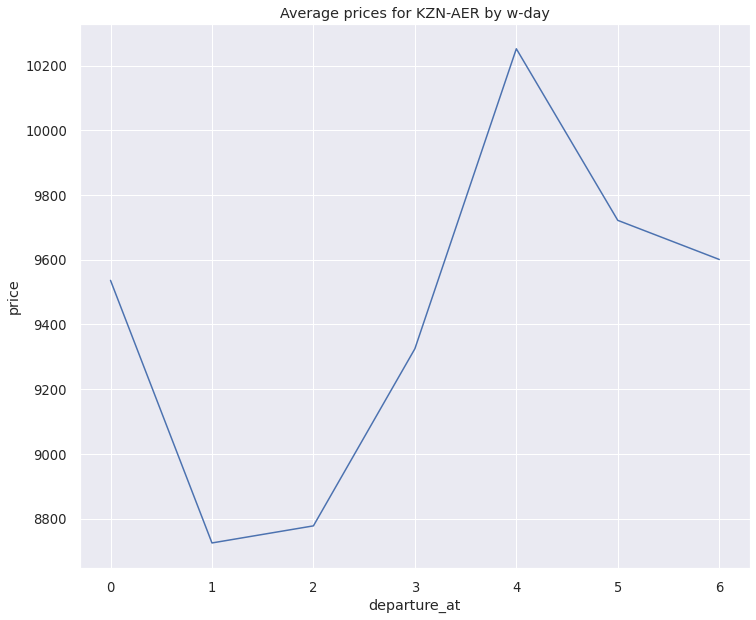

In [41]:
# Avg prices by weekday
kzn_soc_wd = kzn_soc.groupby(kzn_soc['departure_at'].dt.weekday)['price'].mean()
display(kzn_soc_wd)
kwl = sns.lineplot(data=kzn_soc_wd)
kwl.set(title="Average prices for KZN-AER by w-day")

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='price'>)

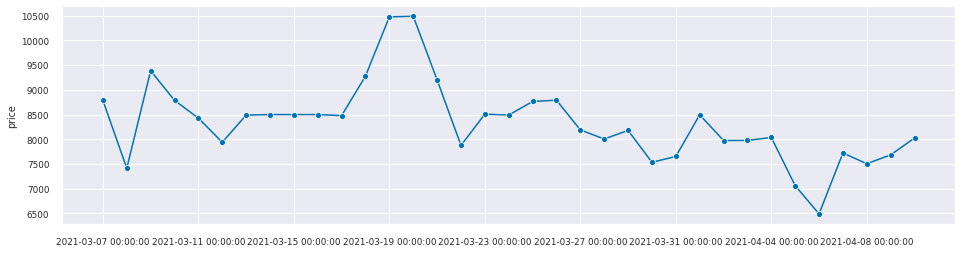

In [42]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.arima import ARIMA, AutoARIMA

sns.set(font_scale=.8)
y = kzn_soc_day
plot_series(y)

26 9


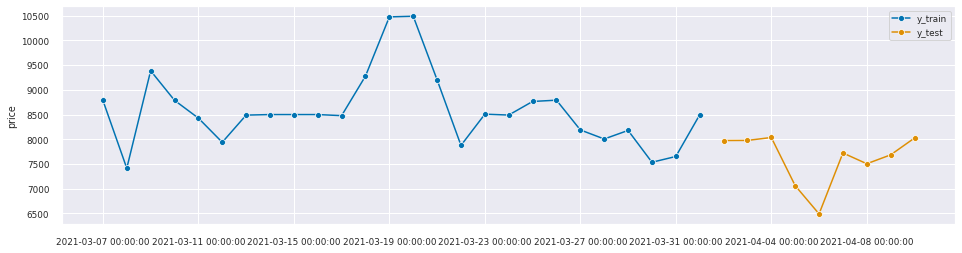

In [43]:
y_train, y_test = temporal_train_test_split(y)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

0.07875037898974681

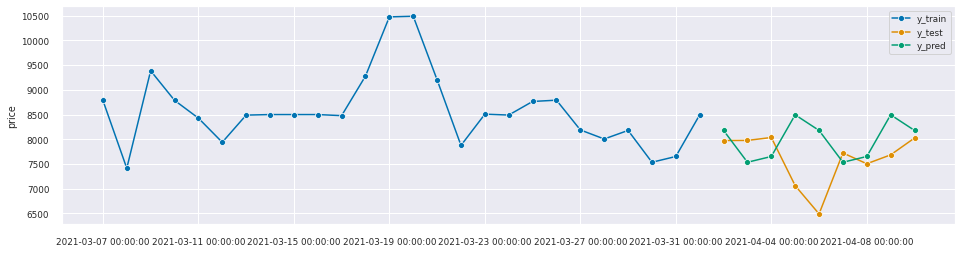

In [44]:
# Naive Forecaster
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy="last", sp=4)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

/home/vladimir/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


0.08988471244675278

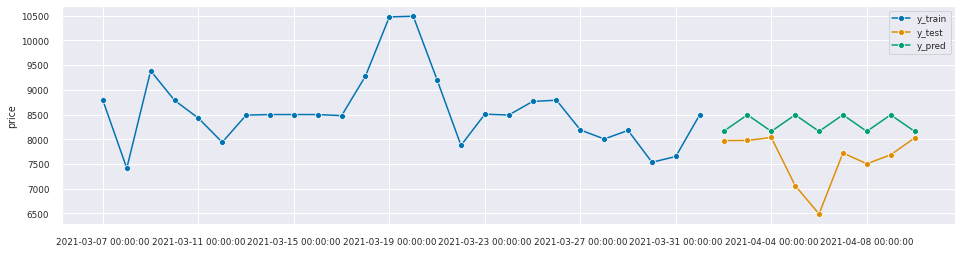

In [45]:
forecaster = AutoARIMA(sp=2) # 2 is best for this case
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

Тренд установился правильно, но присутствует сдвиг вверх

Let's try different destinations, different models, different statistics

По времени до вылета

In [46]:
kzn_soc

,origin,destination,departure_at,airline,flight_number,price,expires_at,requested_at
2187,KZN,AER,2021-03-07 14:00:00,S7,1054,8787.0,2021-03-07 14:00:00,2021-03-06 10:28:54
2188,KZN,AER,2021-03-08 09:25:00,DP,338,10298.0,2021-03-08 09:25:00,2021-03-06 10:28:54
2189,KZN,AER,2021-03-09 18:10:00,N4,137,10201.0,2021-03-08 06:06:18,2021-03-06 10:28:54
2190,KZN,AER,2021-03-10 17:20:00,DP,284,9358.0,2021-03-08 09:24:21,2021-03-06 10:28:54
2191,KZN,AER,2021-03-11 11:45:00,7R,215,8656.0,2021-03-07 10:42:06,2021-03-06 10:28:54
...,...,...,...,...,...,...,...,...
257968,KZN,AER,2021-04-08 13:55:00,S7,1054,8516.0,2021-04-08 13:55:00,2021-04-08 06:30:05
259644,KZN,AER,2021-04-09 08:00:00,DP,338,8198.0,2021-04-09 08:00:00,2021-04-08 12:30:04
259645,KZN,AER,2021-04-10 08:00:00,DP,338,8198.0,2021-04-10 08:00:00,2021-04-08 12:30:04
264526,KZN,AER,2021-04-09 12:50:00,ZF,345,8230.0,2021-04-09 12:50:00,2021-04-09 06:30:04


In [49]:
def predict_prices(orgn, dest):
    #  Avg prices on each day, 2021-03-06 is out
    orgn_dest = df[(df["origin"] == orgn) & (df["destination"] == dest) & (df["departure_at"] <= datetime.datetime.now()) & (df["departure_at"] >= "2021-03-07")]
    # orgn_dest = orgn_dest.dropna()
    orgn_dest_day = orgn_dest.resample('D', on='departure_at')['price'].mean() 
    
    if orgn_dest_day.empty:
        return ("nan", orgn, dest)
    y = orgn_dest_day
    y_train, y_test = temporal_train_test_split(y)
    
    forecaster = AutoARIMA(sp=2, suppress_warnings=True)
    # forecaster = NaiveForecaster(strategy="last")
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
    return (smape_loss(y_test, y_pred), orgn, dest)

[(0.040003789558092556, 'MOW', 'SVX'),
 (0.04480646519989262, 'MOW', 'KZN'),
 (0.05138395894214012, 'MOW', 'CEK'),
 (0.08154452820254468, 'MOW', 'LED'),
 (0.09652367742726987, 'MOW', 'AER')]

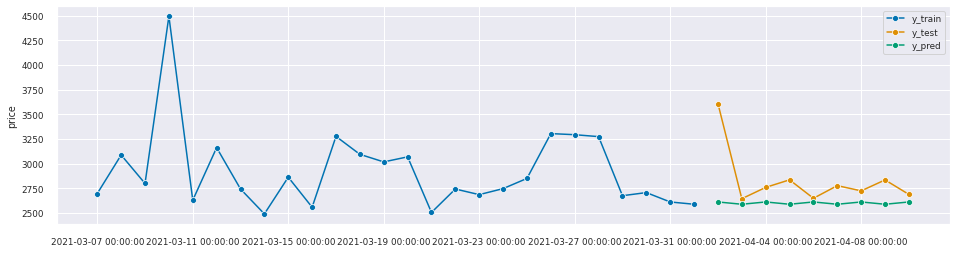

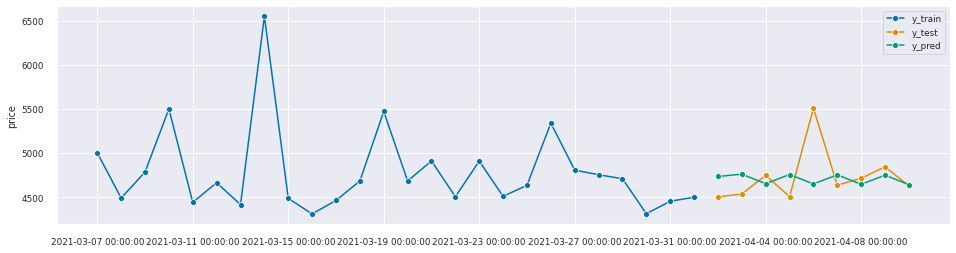

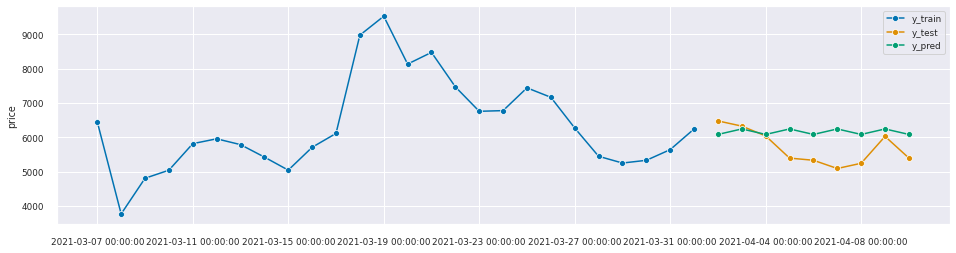

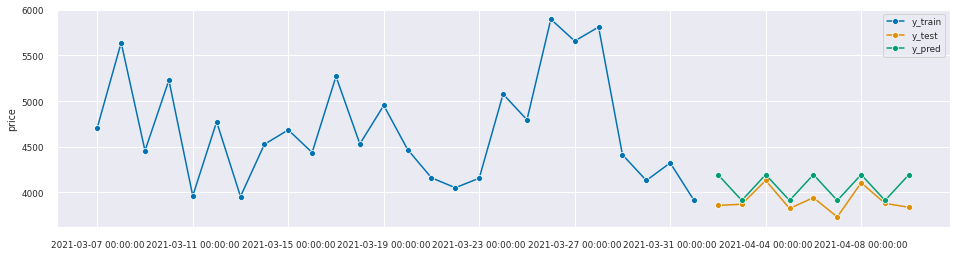

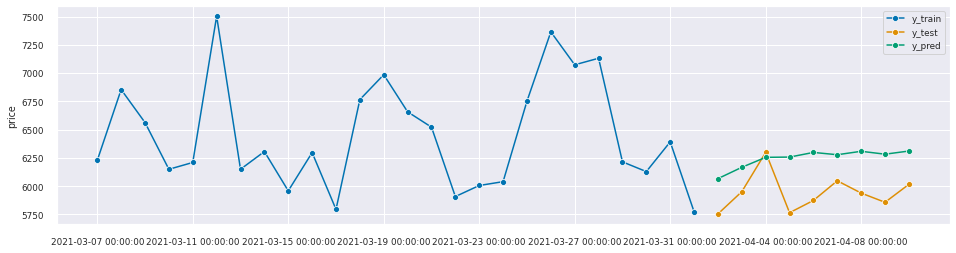

In [50]:
smapes = []
i = "MOW"
#for i in set(df["origin"]):
df_m = df[df["origin"] == "MOW"]
for j in ["LED", "KZN", "AER", "SVX", "CEK"]:
    smapes.append(predict_prices(i, j))
# smapes.append(predict_prices("MOW", "LED"))
clean_smapes = [i for i in smapes if str(i[0]) != "nan"]
clean_smapes.sort()
clean_smapes

Сделать на основе функции выше новую, предсказывающую цены по направлению в зависимости от дней до вылета.

In [53]:
# TODO
def predict_queried_prices(orgn, dest, current_date, flight_date):
    orgn_dest = df[(df["origin"] == orgn) & (df["destination"] == dest) & (df["departure_at"] <= flight_date) 
                   & (df["departure_at"] >= flight_date - datetime.timedelta(days=1))
                   & (df["requested_at"] >= flight_date - datetime.timedelta(days=7))]
    orgn_dest_day_min = orgn_dest.resample('D', on='requested_at')['price'].min() 
    
    if orgn_dest_day_min.empty:
        return ("nan", orgn, dest)
    
    y = orgn_dest_day_min
    y_train, y_test = temporal_train_test_split(y)
    
    forecaster = AutoARIMA()
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [54]:
predict_queried_prices("KZN", "MOW", datetime.datetime.now(), datetime.datetime.now())

/home/vladimir/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/vladimir/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/vladimir/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/vladimir/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/vladimir/miniconda3/envs/ml/lib/python3.7/site-packages/pmdar

ValueError: In-sample predictions undefined for start=-1 when d=0